## Description

In this notebook, we analyze the segmentation results.  

In [1]:
%matplotlib notebook

In [2]:
from masserstein import Spectrum, estimate_proportions
from matplotlib import cm
from matplotlib import pyplot as plt
import numpy as np
from pyimzml.ImzMLParser import ImzMLParser
from pyimzml.ImzMLWriter import ImzMLWriter
from time import time
import pandas as pd
from sklearn.cluster import KMeans
from additional_functions import profile_ion_image, centroided_ion_image, segment_average_spectra, total_spectrum

In [3]:
import numpy.random as rd

In [4]:
analyzed_mass_range = (600, 1000)

In [5]:
cerebellum_image_shape = (21, 81)
bladder_image_shape = (134, 260)

In [6]:
bladder_centroided_image = ImzMLParser('MSimages/bladder_centroided.imzML')
cerebellum_centroided_image = ImzMLParser('MSimages/cerebellum_centroided.imzML')

In [7]:
bladder_profile_image = ImzMLParser('MSimages/HR2MSI mouse urinary bladder S096.imzML')
cerebellum_profile_image = ImzMLParser('MSimages/test_POS.imzML')

/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/mciach/Py3Env/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000584 found with incorrect name "mz

In [8]:
centroided_images = {'cerebellum': cerebellum_centroided_image, 
                     'bladder': bladder_centroided_image}
profile_images = {'cerebellum': cerebellum_profile_image, 
                  'bladder': bladder_profile_image}
image_shapes = {'cerebellum': cerebellum_image_shape, 
                'bladder': bladder_image_shape}
image_names = ['cerebellum', 'bladder']

In [9]:
masserstein_images = {n : np.load(n+'_regression_images.dmp', allow_pickle=True) for n in image_names}
[masserstein_images[n].shape for n in image_names]

[(21, 81, 209), (134, 260, 180)]

In [10]:
lipid_formulas = {n : [] for n in image_names}
detection_vector = {n: [] for n in image_names}  # used to select lipids in the ion images
for i, n in enumerate(image_names):
    with open(n + '_refined_annotation_results.tsv') as h:
        next(h)  # skipping header
        for l in h:
            l = l.strip().split('\t')
            if l[-1] == 'True':  # if the lipid is detected in the image
                lipid_formulas[n].append(l[0])
            detection_vector[n].append(l[-1]=='True')
    assert len(lipid_formulas[n]) == len(set(lipid_formulas[n])), 'Formulas for %s are not unique!' % n      
    print('Loaded %i formulas for %s' % (len(lipid_formulas[n]), n))

Loaded 77 formulas for cerebellum
Loaded 44 formulas for bladder


In [11]:
masserstein_images = {n: masserstein_images[n][..., detection_vector[n]] for n in image_names}
[masserstein_images[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

In [12]:
lipid_spectra = {n: [Spectrum(f, adduct='K', threshold=0.05) for f in lipid_formulas[n]] for n in image_names}
for n in image_names:
    for s in lipid_spectra[n]:
        s.normalize()
        assert analyzed_mass_range[0] <= s.confs[0][0] <= analyzed_mass_range[1]

In [13]:
single_peak_kmeans_segmentation = {n : np.load(n+'_peak_kmeans_segmentation.dmp', allow_pickle=True) for n in image_names}
[single_peak_kmeans_segmentation[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

In [14]:
masserstein_kmeans_segmentation = {n : np.load(n+'_masserstein_kmeans_segmentation.dmp', allow_pickle=True) for n in image_names}
[masserstein_kmeans_segmentation[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

In [15]:
masserstein_sdgmm_segmentation = {n : np.load(n+'_masserstein_sdgmm_segmentation.dmp', allow_pickle=True) for n in image_names}
[masserstein_sdgmm_segmentation[n].shape for n in image_names]

[(21, 81, 77), (134, 260, 44)]

Verify proper loading:

<IPython.core.display.Javascript object>


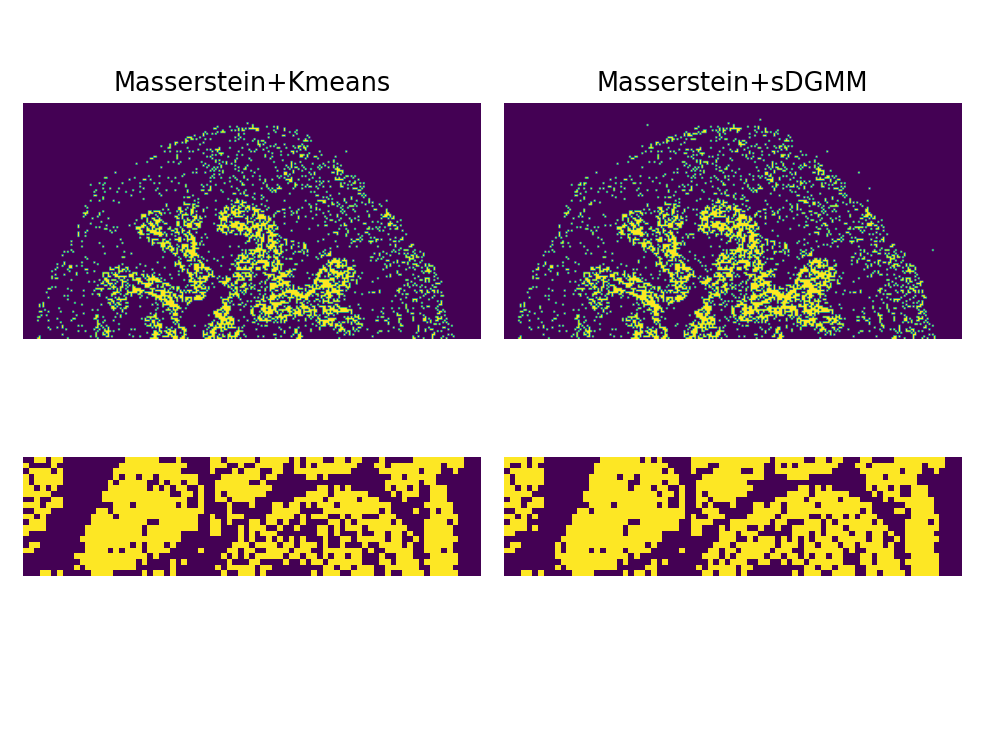

In [16]:
plt.figure()
plt.subplot(221)
plt.title('Masserstein+Kmeans')
plt.imshow(masserstein_kmeans_segmentation['bladder'][..., 12])
plt.axis('off')
plt.subplot(222)
plt.title('Masserstein+sDGMM')
plt.imshow(masserstein_sdgmm_segmentation['bladder'][..., 12])
plt.axis('off')
plt.subplot(223)
plt.imshow(masserstein_kmeans_segmentation['cerebellum'][..., 2])
plt.axis('off')
plt.subplot(224)
plt.imshow(masserstein_sdgmm_segmentation['cerebellum'][..., 2])
plt.axis('off')
plt.tight_layout()
plt.show()

In [17]:
lipid_spectra['cerebellum'][0].formula

'C35H66NO9P'

## Comparing spatialDGMM and Kmeans on masserstein signals

In [18]:
segmentation_agreement_percent = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
segmentation_correlation = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
for n in image_names:
    segmentation_agreement_percent[n] = np.mean(masserstein_sdgmm_segmentation[n] == masserstein_kmeans_segmentation[n], 
                                            axis=(0,1)) 
    mass_standard = masserstein_sdgmm_segmentation[n] - np.mean(masserstein_sdgmm_segmentation[n], axis=(0,1))
    mass_standard = mass_standard / np.std(mass_standard, axis=(0,1))
    kmean_standard = masserstein_kmeans_segmentation[n] - np.mean(masserstein_kmeans_segmentation[n], axis=(0,1))
    kmean_standard = kmean_standard / np.std(kmean_standard, axis=(0,1))
    segmentation_correlation[n] = np.mean(mass_standard*kmean_standard, axis=(0,1))

Average identity for cerebellum: 0.9396306221703047
Average identity for bladder: 0.960900480116898


<IPython.core.display.Javascript object>


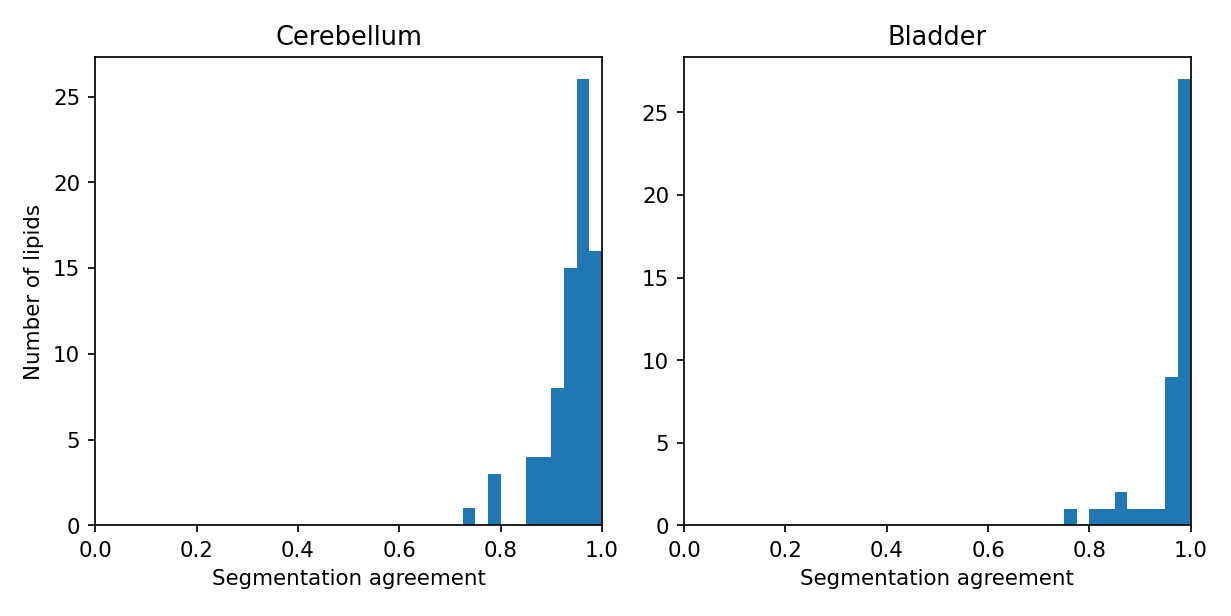

In [19]:
print('Average identity for cerebellum:', np.mean(segmentation_agreement_percent['cerebellum']))
print('Average identity for bladder:', np.mean(segmentation_agreement_percent['bladder']))
plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.title('Cerebellum')
plt.xlim(0,1)
plt.xlabel('Segmentation agreement')
plt.ylabel('Number of lipids')
plt.hist(segmentation_agreement_percent['cerebellum'], bins=np.linspace(0,1,num=41))
plt.subplot(122)
plt.title('Bladder')
plt.xlim(0,1)
plt.xlabel('Segmentation agreement')
plt.hist(segmentation_agreement_percent['bladder'], bins=np.linspace(0,1,num=41))
plt.tight_layout()
plt.savefig('Figs/segmentation/percent_agreement_hist.png', dpi=300)

In [20]:
print(np.sum(segmentation_agreement_percent['cerebellum']>0.9))
print(np.sum(segmentation_agreement_percent['bladder']>0.9))

65
38


Check the lipids for which segmentation differs a lot:

<IPython.core.display.Javascript object>


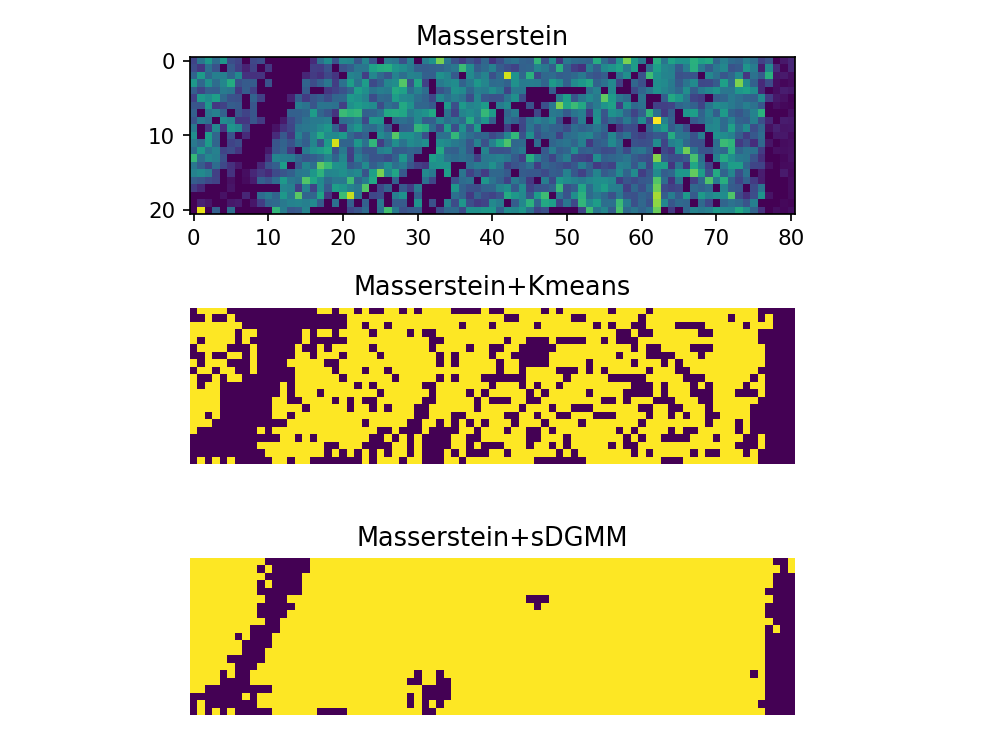

In [21]:
cerebellum_test =np.argmin(segmentation_agreement_percent['cerebellum'])
plt.figure()
plt.subplot(311)
plt.title('Masserstein')
plt.imshow(masserstein_images['cerebellum'][..., cerebellum_test])
plt.subplot(312)
plt.title('Masserstein+Kmeans')
plt.imshow(masserstein_kmeans_segmentation['cerebellum'][..., cerebellum_test])
plt.axis('off')
plt.subplot(313)
plt.title('Masserstein+sDGMM')
plt.imshow(masserstein_sdgmm_segmentation['cerebellum'][..., cerebellum_test])
plt.axis('off')
plt.tight_layout()

Correlation for cerebellum: 0.8660818319718454
Correlation for bladder: 0.8717067645405886


<IPython.core.display.Javascript object>


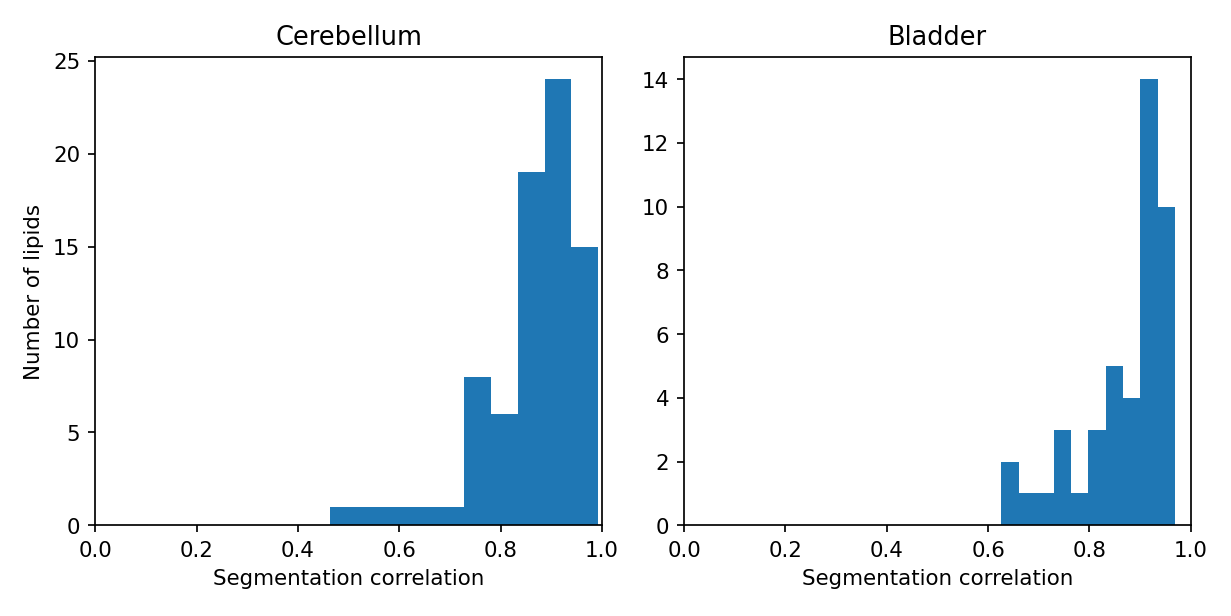

In [22]:
print('Correlation for cerebellum:', np.mean(segmentation_correlation['cerebellum']))
print('Correlation for bladder:', np.mean(segmentation_correlation['bladder']))
plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.title('Cerebellum')
plt.xlim(0,1)
plt.xlabel('Segmentation correlation')
plt.ylabel('Number of lipids')
plt.hist(segmentation_correlation['cerebellum'])
plt.subplot(122)
plt.title('Bladder')
plt.xlim(0,1)
plt.xlabel('Segmentation correlation')
plt.hist(segmentation_correlation['bladder'])
plt.tight_layout()

In [23]:
np.argsort(segmentation_agreement_percent['bladder'])

array([11, 22,  9, 15, 19,  7,  5, 24, 30, 16,  2, 40, 14, 42, 31, 18, 17,
        8, 41,  0, 23,  4, 37, 12, 34, 36, 20,  3, 21, 32, 13, 38, 26, 43,
       27, 33, 10, 25,  1, 29, 39, 28,  6, 35])

<IPython.core.display.Javascript object>


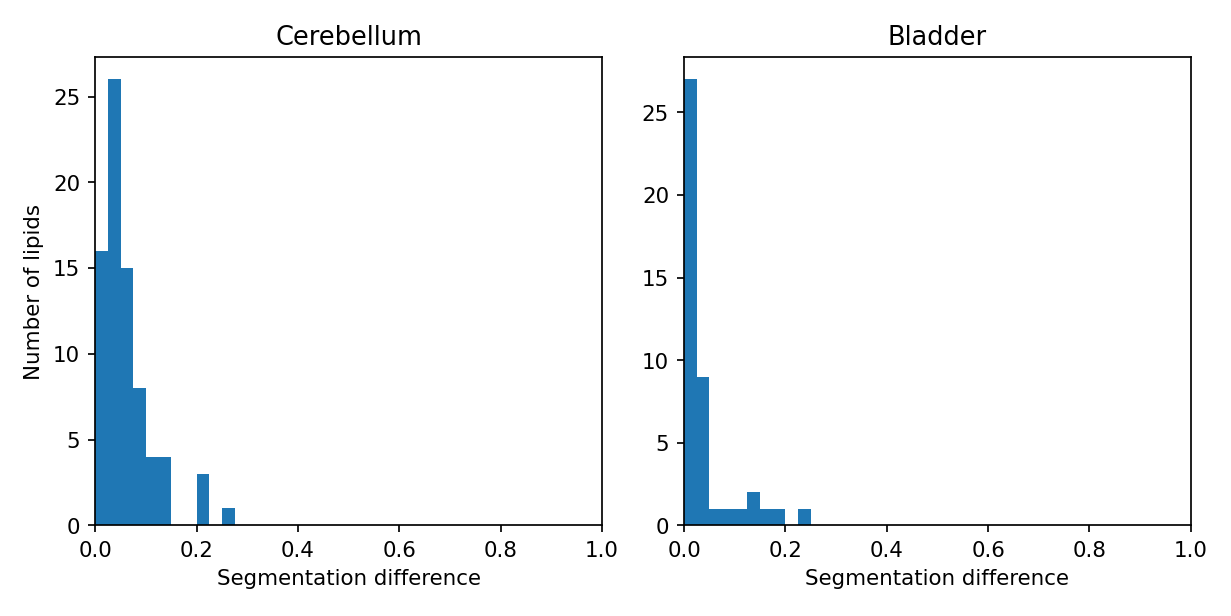

In [24]:
plt.figure(figsize=(8,4), dpi=100)
plt.subplot(121)
plt.title('Cerebellum')
plt.xlim(0,1)
plt.xlabel('Segmentation difference')
plt.ylabel('Number of lipids')
plt.hist(1-segmentation_agreement_percent['cerebellum'], bins=np.linspace(0,1,num=41))
plt.subplot(122)
plt.title('Bladder')
plt.xlim(0,1)
plt.xlabel('Segmentation difference')
plt.hist(1-segmentation_agreement_percent['bladder'], bins=np.linspace(0,1,num=41))
plt.tight_layout()
plt.savefig('Figs/segmentation/sdgmm_kmeans_difference.png', dpi=300)

Compare the segmentations for the cerebellum

In [37]:
print(np.mean(1-segmentation_agreement_percent['cerebellum']))
print(np.median(1-segmentation_agreement_percent['cerebellum']))
print(np.quantile(1-segmentation_agreement_percent['cerebellum'], 0.9))
print(np.max(1-segmentation_agreement_percent['cerebellum']))


0.06036937782969527
0.04174015285126398
0.12275132275132278
0.27219282774838327


In [42]:
most_changed = np.argmax(1-segmentation_agreement_percent['cerebellum'])
lipid_spectra['cerebellum'][most_changed].formula

'C42H80NO9P'

Show lipids with a marked change in segmentation:

In [54]:
large_changes = np.argsort(1-segmentation_agreement_percent['cerebellum'])[-1:-5:-1]

<IPython.core.display.Javascript object>


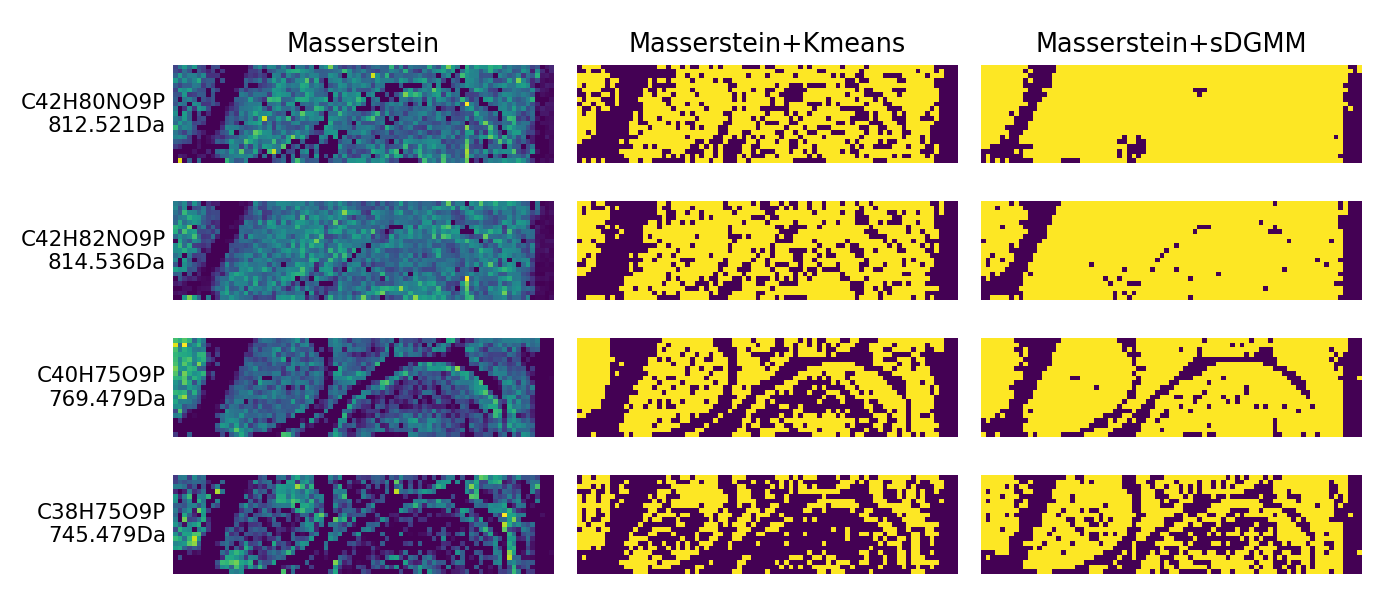

In [75]:
plt.subplots(4,3, figsize=(9,4))
for i, lid in enumerate(large_changes):
    plt.subplot(4,3, 1+3*i)
    if i == 0: plt.title('Masserstein')
    plt.imshow(masserstein_images['cerebellum'][..., lid])
    plt.axis('off')
    plt.text(-2, 10, 
             lipid_spectra['cerebellum'][lid].formula + '\n' + str(round(lipid_spectra['cerebellum'][lid].confs[0][0], 3)) + 'Da', 
             horizontalalignment='right', verticalalignment='center')
    plt.subplot(4,3, 2+3*i)
    if i == 0: plt.title('Masserstein+Kmeans')
    plt.imshow(masserstein_kmeans_segmentation['cerebellum'][..., lid])
    plt.axis('off')
    plt.subplot(4,3, 3+3*i)
    if i == 0: plt.title('Masserstein+sDGMM')
    plt.imshow(masserstein_sdgmm_segmentation['cerebellum'][..., lid])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/segmentation/cerebellum_comparison.png', dpi=300)

In [38]:
print(np.mean(1-segmentation_agreement_percent['bladder']))
print(np.median(1-segmentation_agreement_percent['bladder']))
print(np.quantile(1-segmentation_agreement_percent['bladder'], 0.9))
print(np.max(1-segmentation_agreement_percent['bladder']))


0.03909951988310198
0.015384615384615385
0.13263490241102194
0.22861653272101035


In [80]:
large_changes = np.argsort(1-segmentation_agreement_percent['bladder'])[-1:-5:-1]

<IPython.core.display.Javascript object>


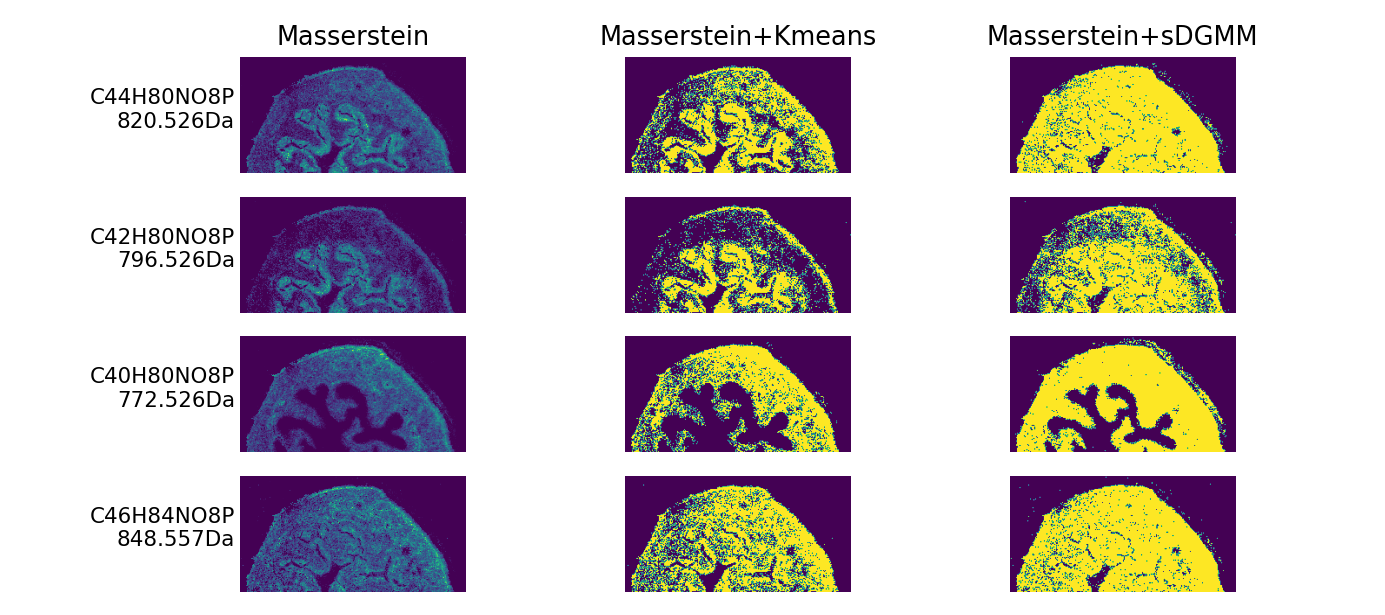

In [85]:
plt.subplots(4,3, figsize=(9,4))
for i, lid in enumerate(large_changes):
    plt.subplot(4,3, 1+3*i)
    if i == 0: plt.title('Masserstein')
    plt.imshow(masserstein_images['bladder'][..., lid])
    plt.axis('off')
    plt.text(-6, 60, 
             lipid_spectra['bladder'][lid].formula + '\n' + str(round(lipid_spectra['bladder'][lid].confs[0][0], 3)) + 'Da', 
             horizontalalignment='right', verticalalignment='center')
    plt.subplot(4,3, 2+3*i)
    if i == 0: plt.title('Masserstein+Kmeans')
    plt.imshow(masserstein_kmeans_segmentation['bladder'][..., lid])
    plt.axis('off')
    plt.subplot(4,3, 3+3*i)
    if i == 0: plt.title('Masserstein+sDGMM')
    plt.imshow(masserstein_sdgmm_segmentation['bladder'][..., lid])
    plt.axis('off')
plt.tight_layout()
plt.savefig('Figs/segmentation/bladder_comparison.png', dpi=300)

In [34]:
print(len(segmentation_agreement_percent['cerebellum']))
print(sum(segmentation_agreement_percent['cerebellum']<1))
print(sum(segmentation_agreement_percent['cerebellum']<0.95))

77
77
35


In [35]:
print(len(segmentation_agreement_percent['bladder']))
print(sum(segmentation_agreement_percent['bladder']<1))
print(sum(segmentation_agreement_percent['bladder']<0.95))

44
44
8


In [29]:
cer_diff = 1-segmentation_agreement_percent['cerebellum']
bld_diff = 1-segmentation_agreement_percent['bladder']

## Spatial consistency 

In [30]:
sdgmm_consistency_scores = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
kmeans_consistency_scores = {n: np.zeros(len(lipid_formulas[n])) for n in image_names}
for n in image_names:
    t = masserstein_sdgmm_segmentation[n]
    r = masserstein_kmeans_segmentation[n]
    for sh1 in [-1, 0, 1]:
        for sh2 in [-1, 0, 1]:
            if sh1 == 0 and sh2 == 0: continue
            sdgmm_consistency_scores[n] += np.sum(t == np.roll(t, (sh1, sh2), axis=(0, 1)), axis=(0, 1))
            kmeans_consistency_scores[n] += np.sum(r == np.roll(r, (sh1, sh2), axis=(0, 1)), axis=(0, 1))
    sdgmm_consistency_scores[n] /= (8*image_shapes[n][0]*image_shapes[n][1])
    kmeans_consistency_scores[n] /= (8*image_shapes[n][0]*image_shapes[n][1])

In [31]:
sdgmm_consistency_scores[n]

array([0.85070321, 0.95099024, 0.8418915 , 0.89546498, 0.94582377,
       0.87027842, 0.96219862, 0.88240528, 0.83072618, 0.93511768,
       0.95332951, 0.91660448, 0.84059989, 0.89361366, 0.83554822,
       0.91153846, 0.88927956, 0.914624  , 0.92739667, 0.94368542,
       0.86509759, 0.87535878, 0.81537026, 0.82465557, 0.83761481,
       0.95513777, 0.92537313, 0.94169059, 0.94621125, 0.93711251,
       0.83754305, 0.90206659, 0.92033582, 0.93572044, 0.91977612,
       0.92319173, 0.93072618, 0.8956372 , 0.91528416, 0.93612227,
       0.92469862, 0.84209242, 0.8836969 , 0.94842135])

In [32]:
kmeans_consistency_scores[n]

array([0.87290471, 0.95622847, 0.86644661, 0.90665901, 0.94985649,
       0.83303674, 0.96498278, 0.83910735, 0.84572331, 0.85782147,
       0.95631458, 0.81568599, 0.85120551, 0.90136338, 0.86475316,
       0.79870838, 0.90734788, 0.90147819, 0.95452067, 0.87099598,
       0.87679392, 0.88241963, 0.83797359, 0.8358496 , 0.89154707,
       0.95851033, 0.93629449, 0.94631171, 0.9505597 , 0.94085821,
       0.87719575, 0.93882032, 0.92832951, 0.93840413, 0.94085821,
       0.9266217 , 0.93239093, 0.90335821, 0.92620551, 0.9391504 ,
       0.9310132 , 0.85275545, 0.89783295, 0.95724742])

Check the percentage improvement of the consistency:

In [33]:
100*(sdgmm_consistency_scores[n]/kmeans_consistency_scores[n] - 1)

array([-2.54340392, -0.54780129, -2.83400139, -1.23464607, -0.42456109,
        4.47059229, -0.28851874,  5.15999932, -1.77329034,  9.01075737,
       -0.31214359, 12.37222232, -1.2459536 , -0.85977678, -3.37725704,
       14.12656772, -1.99133241,  1.45825042, -2.84163522,  8.34555371,
       -1.33398805, -0.80016914, -2.69737969, -1.33923972, -6.04928931,
       -0.35185435, -1.16644441, -0.48833012, -0.45746207, -0.39811468,
       -4.52039331, -3.91488451, -0.86108277, -0.2859852 , -2.24072972,
       -0.37015813, -0.17854669, -0.85470085, -1.17915027, -0.32243276,
       -0.67824827, -1.25042073, -1.57446332, -0.92202516])

In [34]:
n='cerebellum'

<IPython.core.display.Javascript object>


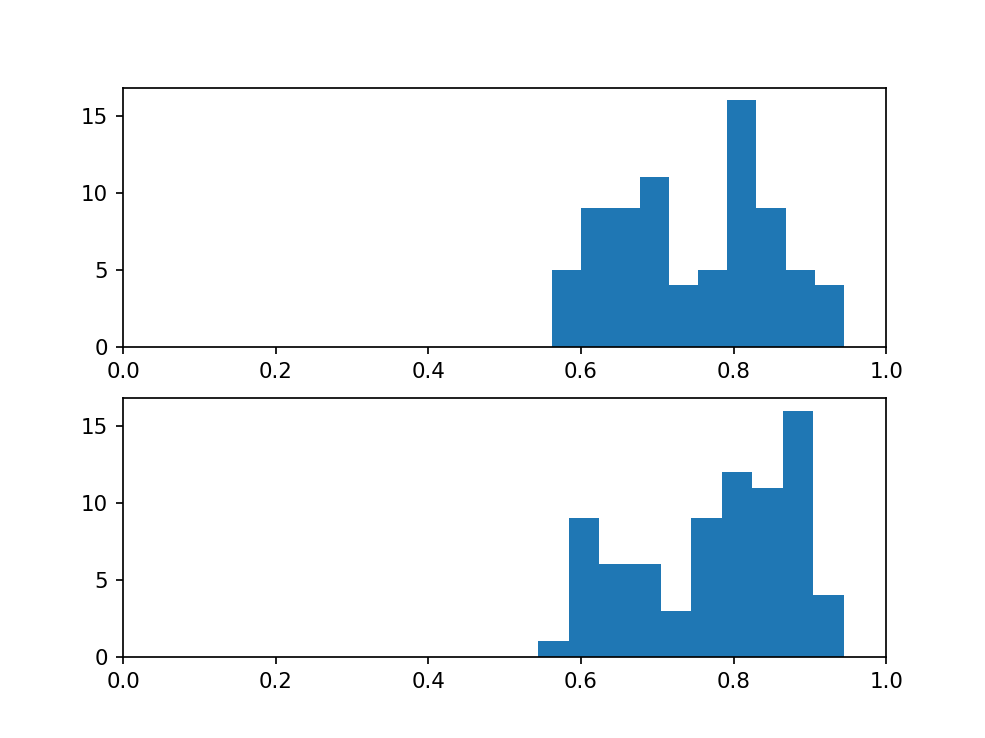

(0.0, 1.0)

In [35]:
plt.figure()
plt.subplot(211)
plt.xlim(0, 1)
plt.hist(kmeans_consistency_scores[n])
plt.subplot(212)
plt.hist(sdgmm_consistency_scores[n])
plt.xlim(0,1)

## Remnants

Optionally, generate and save images and segmentations for each lipid:

In [ ]:
# for image_id, n in enumerate(image_names):
#     intsy_matrix = single_peak_intensities[n]
#     decon_matrix = masserstein_estimation[n]
#     for lipid_id, lipid_sp in enumerate(lipid_spectra[n]):  # remove [:4] when finished
#         # reformat the data for plotting
#         intsy_image = np.zeros(image_shapes[n])
#         decon_image = np.zeros(image_shapes[n])
#         intsy_segm  = np.zeros(image_shapes[n])
#         decon_segm  = np.zeros(image_shapes[n])
#         for i, l in enumerate(intensity_coordinates[n]):
#             intsy_image[l[0], l[1]] = single_peak_intensities[n][i, lipid_id]
#             intsy_segm[l[0], l[1]]  = intensity_segmentation[n][i, lipid_id]
#         for i, l in enumerate(masserstein_coordinates[n]):
#             decon_image[l[0], l[1]] = masserstein_estimation[n][i, lipid_id]
#             decon_segm[l[0], l[1]]  = masserstein_segmentation[n][i, lipid_id]
#         plt.figure()
        
#         plt.subplot(2, 2, 1)
#         plt.title('Peak (profile)\n' + str(round(lipid_sp.confs[0][0], 3)))
#         plt.imshow(intsy_image, interpolation='none', cmap=cm.magma)
#         plt.axis('off')
        
#         plt.subplot(2, 2, 2)
#         plt.title('Masserstein\n' + lipid_sp.formula)
#         plt.imshow(decon_image, interpolation='none', cmap=cm.magma)
#         plt.axis('off')
        
#         plt.subplot(2, 2, 3)
#         plt.title('K-means')
#         plt.imshow(intsy_segm, interpolation='none', cmap=cm.hot)
#         plt.axis('off')
        
#         plt.subplot(2, 2, 4)
#         plt.title('sDGMM')
#         plt.imshow(decon_segm, interpolation='none', cmap=cm.hot)
#         plt.axis('off')
        
#         plt.tight_layout()
#         plt.savefig('Figs/' + n + '_segmentation/%i.png' % lipid_id, dpi=300)
#         plt.close()

## Generating summary plots

Generate and save images with full data on segments: 

In [36]:
for image_id, n in enumerate(image_names):
    print(n)
    full_mass_axis = np.arange(600, 1000, 0.001)
    image_total_spectrum = total_spectrum(profile_images[n], full_mass_axis)
    image_total_spectrum = np.array(image_total_spectrum)
    for lipid_id, lipid_sp in enumerate(lipid_spectra[n][8:18]):
        lipid_id += 8
        print(lipid_id)
        # split peak intensities and masserstein estimates per segment
        single_peak_in_clusters = []
        masserstein_in_clusters = []
        for segment_id in range(1, 3):  # skipping the background cluster
            kmeans_segment_mask = single_peak_kmeans_segmentation[n][..., lipid_id]==segment_id
            sdgmm_segment_mask = masserstein_sdgmm_segmentation[n][..., lipid_id]==segment_id
            single_peak_in_clusters.append(intensity_images[n][kmeans_segment_mask, lipid_id])
            masserstein_in_clusters.append(masserstein_images[n][sdgmm_segment_mask, lipid_id])
        
        nbh_lbound = lipid_sp.confs[0][0] - 1.2
        nbh_ubound = lipid_sp.confs[0][0] + 2.2
        in_nbh = (full_mass_axis >= nbh_lbound)*(full_mass_axis<=nbh_ubound)
        local_mass_axis = full_mass_axis[in_nbh]
        local_total = image_total_spectrum[in_nbh]
        monoisotopic_total = local_total[np.searchsorted(local_mass_axis, lipid_sp.confs[0][0])]
        
        intensity_per_segment = []
        masserstein_per_segment = []
        for segment_id in range(3):
            intensity_per_segment.append(total_spectrum(profile_images[n], 
                                                        local_mass_axis, 
                                                        single_peak_kmeans_segmentation[n][..., lipid_id] == segment_id))
            masserstein_per_segment.append(total_spectrum(profile_images[n], 
                                                        local_mass_axis, 
                                                        masserstein_sdgmm_segmentation[n][..., lipid_id] == segment_id))
        intensity_per_segment = np.array(intensity_per_segment)
        masserstein_per_segment = np.array(masserstein_per_segment)
        #assert np.all(np.sum(intensity_per_segment, axis=0) == total)
        #assert np.all(np.sum(masserstein_per_segment, axis=0) == total)
        # intensity_cluster_spectra = segment_average_spectra(profile_images[n], single_peak_kmeans_segmentation[n][..., lipid_id], mass_axis)
        # masserstein_cluster_spectra = segment_average_spectra(profile_images[n], masserstein_sdgmm_segmentation[n][..., lipid_id], mass_axis)
        plt.figure(figsize=(7.6, 10), dpi=300)
        
        plt.subplot(4, 2, 1)
        plt.title('Peak (profile)\n' + str(round(lipid_sp.confs[0][0], 3)))
        plt.imshow(intensity_images[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 2)
        plt.title('Masserstein\n' + lipid_sp.formula)
        plt.imshow(masserstein_images[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 3)
        plt.title('K-means')
        plt.imshow(single_peak_kmeans_segmentation[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 4)
        plt.title('sDGMM')
        plt.imshow(masserstein_sdgmm_segmentation[n][..., lipid_id])
        plt.axis('off')
        
        plt.subplot(4, 2, 5)
        plt.title('Peak intensity\nper cluster')
        plt.hist(single_peak_in_clusters, stacked=True, bins=80)
        
        plt.subplot(4, 2, 6)
        plt.title('Estimated signal\nper cluster')
        plt.hist(masserstein_in_clusters, stacked=True, bins=80)
        
        plt.subplot(4, 2, 7)
        plt.title('AV')
        plt.plot(local_mass_axis, local_total, lw=0.1, color='k', alpha=0.5)
        plt.annotate('', 
                     xy=(lipid_sp.confs[0][0], monoisotopic_total), 
                     xytext=(lipid_sp.confs[0][0]+0.5, monoisotopic_total+0.5),
                     arrowprops=dict(facecolor='black', width=2))
        for segment_id in range(3):
            plt.fill_between(local_mass_axis, 
                             np.sum(intensity_per_segment[:segment_id,], axis=0),
                             np.sum(intensity_per_segment[:(segment_id+1), ], axis=0),
                             alpha=0.8)
        
        plt.legend(['Total'] + ['Cluster %i' % cl_id for cl_id in range(3)])
        plt.xlim(nbh_lbound, nbh_ubound)
        
        plt.subplot(4, 2, 8)
        plt.plot(local_mass_axis, local_total, lw=0.1, color='k', alpha=0.5)
        (lipid_sp*(monoisotopic_total/lipid_sp.confs[0][1])).plot(show=False, lw=0.5, color='k', alpha=0.5)
        for segment_id in range(3):
            plt.fill_between(local_mass_axis, 
                             np.sum(masserstein_per_segment[:segment_id,], axis=0),
                             np.sum(masserstein_per_segment[:(segment_id+1), ], axis=0),
                             alpha=0.8)
        plt.legend(['Total'] + ['Cluster %i' % cl_id for cl_id in range(3)])
        plt.xlim(nbh_lbound, nbh_ubound)

        plt.tight_layout()
        plt.savefig('Figs/' + n + '_combined_results/%i.png' % lipid_id, dpi=600)
        plt.close()

cerebellum
8


NameError: name 'intensity_images' is not defined